In [1]:
import collections
from pathlib import Path
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
int_columns = ['borough', 'block', 'lot', 'residential units', 'commercial units', 'total units']
nullable_int_columns = ['land square feet', 'gross square feet', 'sale price', 'year built']

# Get the Excel sheet from http://www.data-manual.com/datafiles/rollingsales_manhattan.xls, then "Save to CSV"
# using Excel -- parsing from Python didn't work properly because it mixes up 0 and NaN

def preprocess_csv(csv):
    df = pd.read_csv(csv, header=4, na_values=' -   ', thousands=',', parse_dates=['SALE DATE'])    
    df.columns = [c.lower().strip() for c in df.columns]
    df = df.drop(columns=['borough', 'ease-ment', 'apartment number'])
    for bc in ['building class at present', 'building class at time of sale']:
        df['coarse ' + bc] = df[bc].str.extract('^(.)')
    df.loc[df['year built'] == 0, 'year built'] = float('nan')
    df['zip code'] = df['zip code'].astype('str')
    return df

df = preprocess_csv('data/rollingsales_manhattan.csv')
df.head(5).T
len(df)

,0,1,2,3,4
neighborhood,ALPHABET CITY,ALPHABET CITY,ALPHABET CITY,ALPHABET CITY,ALPHABET CITY
building class category,03 THREE FAMILY DWELLINGS,07 RENTALS - WALKUP APARTMENTS,07 RENTALS - WALKUP APARTMENTS,07 RENTALS - WALKUP APARTMENTS,07 RENTALS - WALKUP APARTMENTS
tax class at present,1,2,2,2,2
block,376,375,399,399,399
lot,24,28,26,39,39
building class at present,C0,C4,C7,C7,C7
address,264 EAST 7TH STREET,738 EAST 6TH STREET,234 EAST 4TH STREET,197 EAST 3RD STREET,197 EAST 3RD STREET
zip code,10009,10009,10009,10009,10009
residential units,3,11,28,16,16
commercial units,NaN,NaN,3,1,1


18926

In [3]:
df['coarse building class at time of sale'].value_counts().head()
# R = condo, D = elevator, C = multiple families, H = hotel, O = office

R    10052
D     6098
C     1562
H      407
O      128
Name: coarse building class at time of sale, dtype: int64

In [4]:
top_building_classes = set(df['coarse building class at time of sale'].value_counts().head().index)
df_top_building_classes = df[df['coarse building class at time of sale'].isin(top_building_classes)]

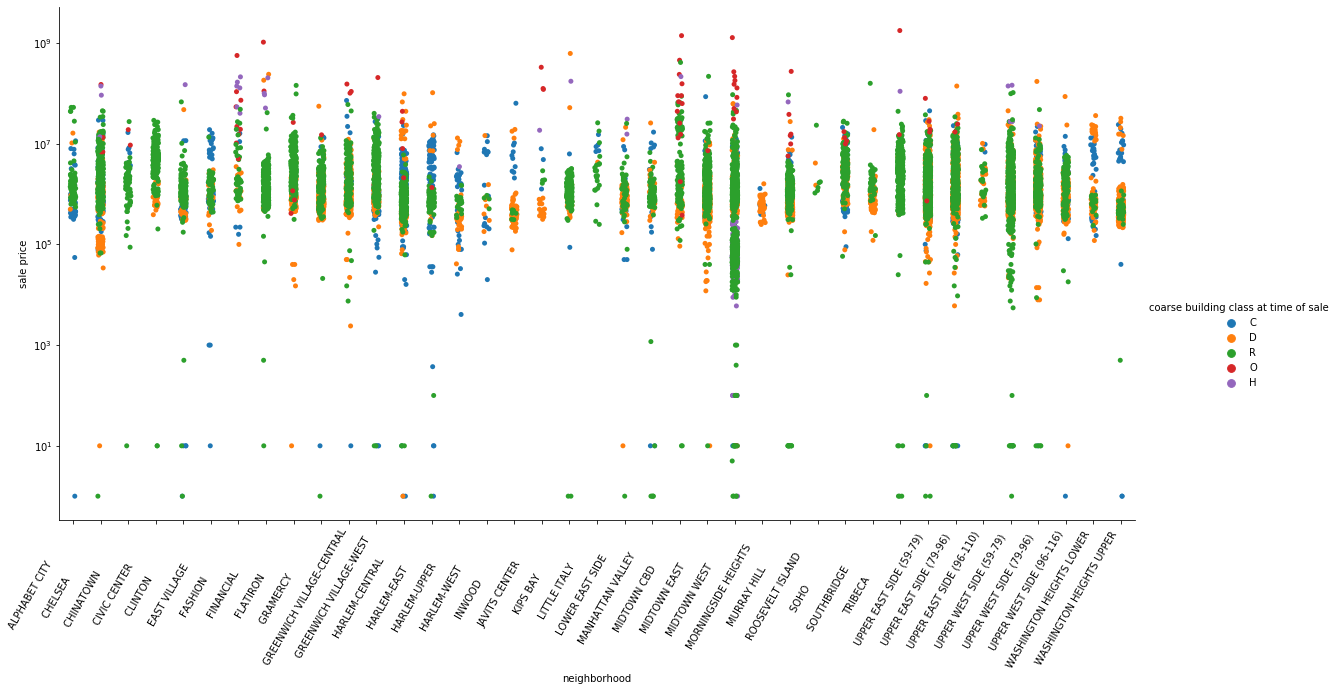

In [8]:
g = sns.catplot(x='neighborhood', y='sale price', data=df_top_building_classes, #kind='swarm',
                hue='coarse building class at time of sale', height=8, aspect=2)
g.set_xticklabels(rotation=60, ha='right')
g.ax.set_yscale('log')

In [51]:
by_neighborhood = df[['neighborhood', 'sale price']].groupby('neighborhood').agg([np.median, lambda p: np.nanpercentile(p, 90), np.max])
by_neighborhood.columns = ['median', 'p90', 'max']
by_neighborhood.sort_values('p90', ascending=False).head(10)

,median,p90,max
neighborhood,,,
FASHION,2576250.0,53834800.0,5.650000e+08
MIDTOWN CBD,2000000.0,42515436.4,1.400000e+09
JAVITS CENTER,1045000.0,31955000.0,3.300000e+08
WASHINGTON HEIGHTS LOWER,805000.0,17201317.6,3.616154e+07
LITTLE ITALY,3900000.0,15200000.0,5.500000e+07
CIVIC CENTER,4625000.0,10146148.4,2.908269e+07
SOHO,3112500.0,9950143.3,9.300000e+07
GREENWICH VILLAGE-WEST,1600000.0,9924732.3,2.059618e+08
ROOSEVELT ISLAND,1594500.0,9878610.4,2.329674e+07


/Users/max.friedrich/miniconda3/envs/max/lib/python3.6/site-packages/statsmodels/robust/robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)


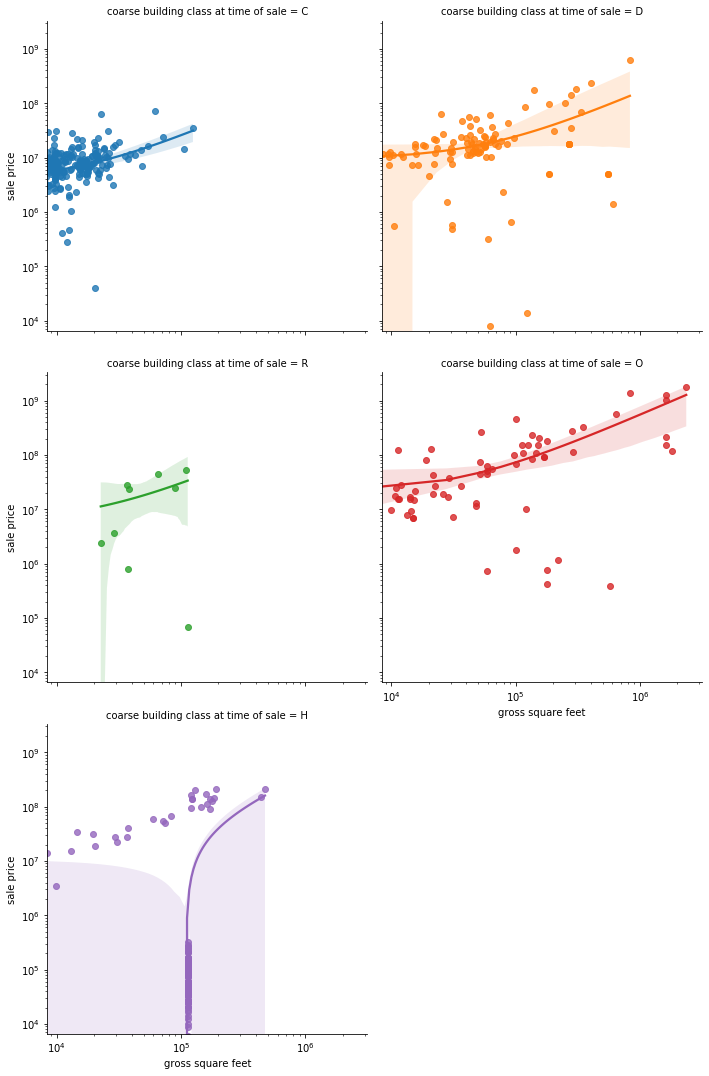

In [10]:
df_cleaned = df_top_building_classes[(df_top_building_classes['sale price'] != 0) & (df_top_building_classes['gross square feet'] > 100)]

g = sns.lmplot(x='gross square feet', y='sale price', col='coarse building class at time of sale',
               hue='coarse building class at time of sale', data=df_cleaned, robust=True, col_wrap=2)
for ax in g.axes:
    ax.set_yscale('log')
    ax.set_xscale('log')

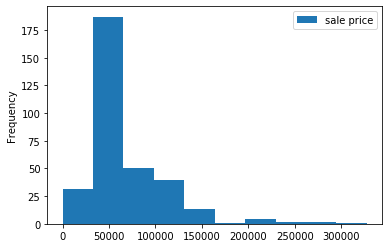

In [11]:
# 102 WEST 57TH STREET Hotel was sold multiple times for many different prices
df_top_building_classes[(df_top_building_classes['coarse building class at time of sale'] == 'H') & 
                        (df_top_building_classes['gross square feet'] == 112850)][['sale price']].plot.hist()

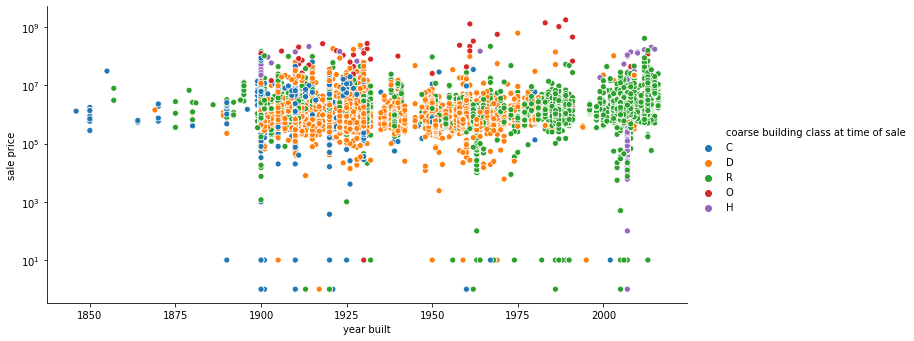

In [54]:
g = sns.relplot(x='year built', y='sale price', hue='coarse building class at time of sale', data=df_top_building_classes, height=5, aspect=2)
g.ax.set_yscale('log')